# Trabalho A2 - Simulação de Epidemias

### Disciplina: Ciência de Redes
### FGV - Ciência de Dados

---

### Integrantes: João Gabriel Machado, Guilherme Buss e Vinicius Nascimento
### Professor: Moacyr Silva

---

## Introdução

Nesse trabalho, vamos apresentar simulações de propagação de epidemias utilizando o modelo Suscetível-Infectado-Susceptível (SIS) em duas arquiteturas de rede distintas:

- Redes Aleatórias (Erdős-Rényi - ER): Análise da fixação da doença em relação ao parâmetro $R_0$.

- Redes Livres de Escala (Scale-Free): Investigação do limiar epidêmico e comparação com a Rede ER, destacando o papel dos hubs.

## Parâmetros Principais

- Modelo: SIS 

- Parâmetros: $\beta$ (taxa de infecção), $\mu$ (taxa de recuperação)

- Métrica Central: Número Reprodutivo Básico ($R_0 = \frac{\beta \langle k \rangle}{\mu}$)

In [11]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import seaborn as sns

seed = 42

# Configuração estética para plots
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

## **Questão 1)**

Gere uma **rede aleatória (ER)** com $N = 10000$ vértices e grau médio $<k> = 20$. Comece com $I_0 = 5$ vértices infectados escolhidos aleatoriamente. Execute múltiplas simulações da propagação da infecção pelo **modelo SIS** (Suscetível-Infectado-Suscetível) com os parâmetros abaixo e compare com os resultados esperados. (Sugestão: faça em torno de 100 simulações e descreva o comportamento da epidemia "na média").

---

Os parâmetros de simulação são:

| Cenário | Taxa de Infecção ($\beta$) | Taxa de Recuperação ($\mu$) | 
| :---: | :---: | :---: | 
| a. | $0.02$ | $0.1$ |
| b. | $0.02$ | $0.4$ | 
| c. | $0.02$ | $0.5$ | 

---

Mostre que se a **Razão de Reprodução Básica** $R_0 = \frac{\beta<k>}{\mu} > 1$ então a doença se fixa na rede no modelo SIS de campo médio.

## **Solução:**

In [21]:
# Parametros dados
N = 10000
k_mean = 20
infected_0 = 5
p = k_mean/N
beta = 0.02
mu_list = [0.1, 0.4, 0.5]

In [26]:
def SIS_epidemy(network, N, beta, mu, i_0, max_epoch=100):
    history = {}
    
    # Inicialização dos infectados
    initial_infected_ids = random.sample(list(network.nodes()), i_0)
    for node_id in initial_infected_ids:
        network.nodes[node_id]['state'] = "I"

    # Contadores iniciais
    infected_count = i_0
    
    # A iteração sobre o tempo
    for epoch in range(max_epoch):
        # Listas temporárias para atualizações síncronas (ou quase síncronas no passo)
        new_infected_ids = []
        new_suscetivel_ids = []
        
        # Varredura de nós
        for node_id in network.nodes():
            if network.nodes[node_id]['state'] == "I": 
                
                # 1. Tentativa de Infecção (Espalhar para vizinhos S)
                for neighbor_id in network.neighbors(node_id):
                    if network.nodes[neighbor_id]['state'] == "S":
                        if np.random.random() < beta:
                            new_infected_ids.append(neighbor_id)
                            
                # 2. Tentativa de Recuperação (I -> S)
                if np.random.random() < mu:
                    new_suscetivel_ids.append(node_id)

        # Novos infectados
        for node_id in new_infected_ids:
            # Verifica novamente se é S (para evitar conflito de múltiplos vizinhos infectando o mesmo)
            if network.nodes[node_id]['state'] == "S":
                network.nodes[node_id]['state'] = "I"
                infected_count += 1

        # Curados
        for node_id in new_suscetivel_ids:
            if network.nodes[node_id]['state'] == "I":
                network.nodes[node_id]['state'] = "S"
                infected_count -= 1
                
        # Salva o estado atual
        history[epoch] = {"infected": infected_count, "suscetivels": N - infected_count}
    
    return history

In [28]:
N = 10000
k_mean = 20
p = k_mean / N
seed = 42

print("Gerando Rede Aleatória (ER)...")
network_er_init = nx.erdos_renyi_graph(N, p, seed=seed)

# Parâmetros da simulação
beta_er = 0.02
mu_list_er = [0.1, 0.4, 0.5]
i_0 = 5
simulations = 100

results_er = {}

print("Iniciando simulações Q1...")

for mu in mu_list_er:
    batch_results = []
    for _ in range(simulations):
        # Cópia da rede para garantir independência
        network_sim = network_er_init.copy()
        nx.set_node_attributes(network_sim, "S", name="state")
        
        # Executa simulação
        history = SIS_epidemy(network_sim, N, beta_er, mu, i_0)
        batch_results.append(history)
    
    results_er[mu] = batch_results
    print(f"Cenário mu={mu} finalizado.")

print("Todas as simulações Q1 concluídas.")

Gerando Rede Aleatória (ER)...
Iniciando simulações Q1...
Cenário mu=0.1 finalizado.
Cenário mu=0.4 finalizado.
Cenário mu=0.5 finalizado.
Todas as simulações Q1 concluídas.


<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
C:\Users\guibu\AppData\Local\Temp\ipykernel_27516\4118490798.py:30: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f'Cenário $\mu={mu}$\n$R_0 = {R0_er:.2f}$')


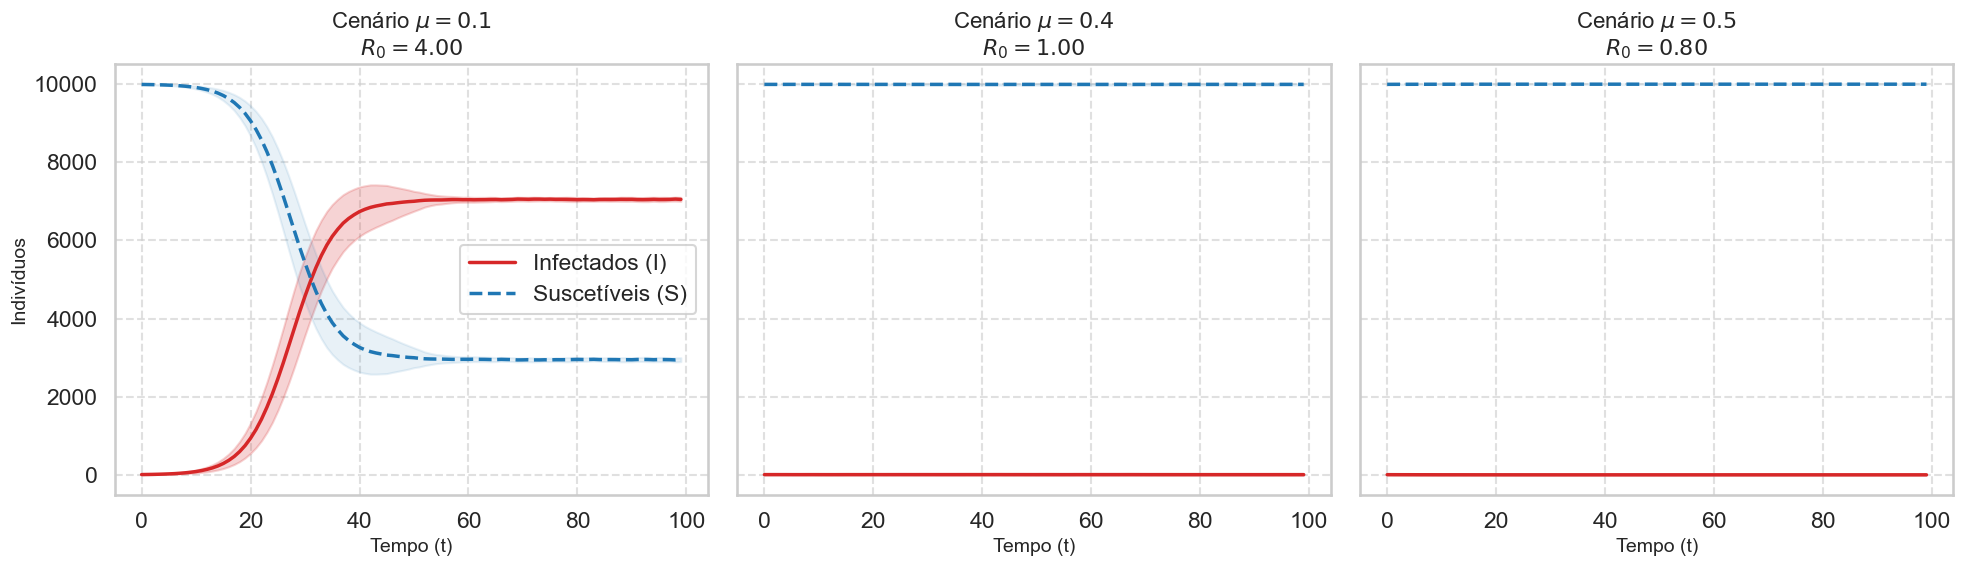

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, mu in enumerate(mu_list_er):
    ax = axes[i]
    batch = results_er[mu]
    
    # Preparação dos dados para plotagem (Matrizes numpy)
    epochs = list(batch[0].keys())
    all_infected = np.array([[run[t]['infected'] for t in epochs] for run in batch])
    all_susceptible = np.array([[run[t]['suscetivels'] for t in epochs] for run in batch])
    
    # Médias e Desvios
    mean_I = np.mean(all_infected, axis=0)
    std_I = np.std(all_infected, axis=0)
    mean_S = np.mean(all_susceptible, axis=0)
    std_S = np.std(all_susceptible, axis=0)
    
    # R0 = (beta * <k>) / mu
    R0_er = (beta_er * k_mean) / mu
    
    # Plot Infectados (Vermelho)
    ax.plot(epochs, mean_I, color='#d62728', label='Infectados (I)', lw=2.5)
    ax.fill_between(epochs, mean_I - std_I, mean_I + std_I, color='#d62728', alpha=0.2)
    
    # Plot Suscetíveis (Azul)
    ax.plot(epochs, mean_S, color='#1f77b4', label='Suscetíveis (S)', lw=2.5, linestyle='--')
    ax.fill_between(epochs, mean_S - std_S, mean_S + std_S, color='#1f77b4', alpha=0.1)
    
    # Estética
    ax.set_title(f'Cenário $\mu={mu}$\n$R_0 = {R0_er:.2f}$')
    ax.set_xlabel('Tempo (t)')
    ax.grid(True, which='major', linestyle='--', alpha=0.6)
    
    if i == 0:
        ax.set_ylabel('Indivíduos')
        ax.legend(loc='center right')

plt.tight_layout()
plt.show()

**Observação Visual:**
Os gráficos confirmam que a epidemia só se sustenta (fixa) no **Cenário 1 ($\mu=0.1$)**, onde calculamos $R_0 = 4.00$. Nos cenários onde $R_0 \leq 1$, a infecção é extinta rapidamente.

**Demonstração Matemática:**
A variação da fração de infectados ($i$) no tempo é o saldo entre contágio e recuperação:
$$\frac{di}{dt} = \beta \langle k \rangle i(1-i) - \mu i$$

Para que a doença cresça inicialmente ($\frac{di}{dt} > 0$) quando a fração de infectados é pequena ($i \approx 0$, logo $1-i \approx 1$):
$$\beta \langle k \rangle i - \mu i > 0$$
$$\beta \langle k \rangle > \mu$$

Dividindo por $\mu$:
$$\frac{\beta \langle k \rangle}{\mu} > 1 \implies \mathbf{R_0 > 1}$$

Conclui-se que **$R_0 > 1$** é a condição obrigatória para a fixação do estado endêmico.

# **Questão 2**

Gere uma **rede "livre de escala" (Scale-Free, SF)** com $N = 10000$ vértices, grau médio $<k> = 20$ e expoente $\gamma = 2.5$. Comece com $I_0 = 5$ vértices infectados escolhidos aleatoriamente. Execute múltiplas simulações da propagação da infecção pelo **modelo SIS** (Suscetível-Infectado-Suscetível) com os parâmetros abaixo e compare com os resultados esperados. (Sugestão: faça em torno de 100 simulações e descreva o comportamento da epidemia "na média").


Os parâmetros de simulação são:

| Cenário | Taxa de Infecção ($\beta$) | Taxa de Recuperação ($\mu$) |
| :---: | :---: | :---: |
| a. | $0.01$ | $0.1$ |
| b. | $0.01$ | $0.2$ | 
| c. | $0.01$ | $0.3$ |


Descreva o comportamento da epidemia e **compare com os resultados do item 1** (Rede Aleatória - ER).

## **Solução:**

Nesta etapa, investigamos a propagação em uma topologia heterogênea. Diferente das redes aleatórias (ER), as redes Livres de Escala (Scale-Free) possuem uma distribuição de graus que segue uma Lei de Potência:

$$P(k) \sim k^{-\gamma}$$

Para gerar esta rede com $\gamma = 2.5$ e grau médio $\langle k \rangle = 20$, utilizamos o **Configuration Model**. Este método nos permite fixar a sequência de graus desejada e conectar os nós aleatoriamente, preservando a estatística dos *hubs*.

In [30]:
gamma = 2.5
k_mean = 20
N = 10000

# 1. Gerar sequência de graus via distribuição de Pareto (Lei de Potência)
shape = gamma - 1
degree_sequence = (np.random.pareto(shape, N) + 1) 

# 2. Normalização para atingir o grau médio alvo <k> = 20
current_mean = np.mean(degree_sequence)
degree_sequence = degree_sequence * (k_mean / current_mean)
degree_sequence = np.round(degree_sequence).astype(int)

# 3. Ajuste de paridade (soma dos graus deve ser par para formar arestas)
if np.sum(degree_sequence) % 2 != 0:
    degree_sequence[0] += 1

# 4. Construção da rede via Configuration Model
# Convertemos para Graph simples removendo auto-loops e arestas paralelas
network_sf_multi = nx.configuration_model(degree_sequence, seed=seed)
network_sf = nx.Graph(network_sf_multi)
network_sf.remove_edges_from(nx.selfloop_edges(network_sf))

# Análise estatística da rede gerada
degrees = np.array([d for n, d in network_sf.degree()])
k_mean_real = np.mean(degrees)
k_2_mean_real = np.mean(degrees**2)
kappa = k_2_mean_real / k_mean_real

print(f"Rede SF gerada: <k> = {k_mean_real:.2f}, Heterogeneidade (<k^2>/<k>) = {kappa:.2f}")

Rede SF gerada: <k> = 18.23, Heterogeneidade (<k^2>/<k>) = 269.19


### Execução das Simulações (SF)

Executamos o modelo SIS. Diferente da versão anterior, aqui armazenaremos tanto o histórico de infectados quanto de suscetíveis para visualização completa.

In [31]:
beta_sf = 0.01
mu_list_sf = [0.1, 0.2, 0.3]
simulations = 100
infected_0 = 5
results_sf = {} 

print(f"Iniciando simulações para Rede Scale-Free...")

for mu in mu_list_sf:
    batch_results = []
    for i in range(simulations):
        # Cópia profunda da rede para garantir independência estatística
        network_sim = network_sf.copy()
        nx.set_node_attributes(network_sim, "S", name="state")
        
        # Reutilizando a função da Questão 1
        history = SIS_epidemy(network_sim, N, beta_sf, mu, infected_0)
        batch_results.append(history)
        
    results_sf[mu] = batch_results

print("Simulações concluídas.")

Iniciando simulações para Rede Scale-Free...
Simulações concluídas.


### Visualização da Dinâmica SF

Os gráficos abaixo mostram a evolução temporal da epidemia.

* **Linhas Sólidas:** Representam a média das simulações ("Campo Médio").
* **Áreas Sombreadas:** Representam o desvio padrão (variabilidade estocástica).
* **Cores:**
    * **Vermelho**: População Infectada ($I$).
    * **Azul**: População Suscetível ($S$).

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
C:\Users\guibu\AppData\Local\Temp\ipykernel_27516\3583880384.py:32: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f'Cenário $\mu={mu}$\n$R_0 \\approx {R0_approx:.2f}$')


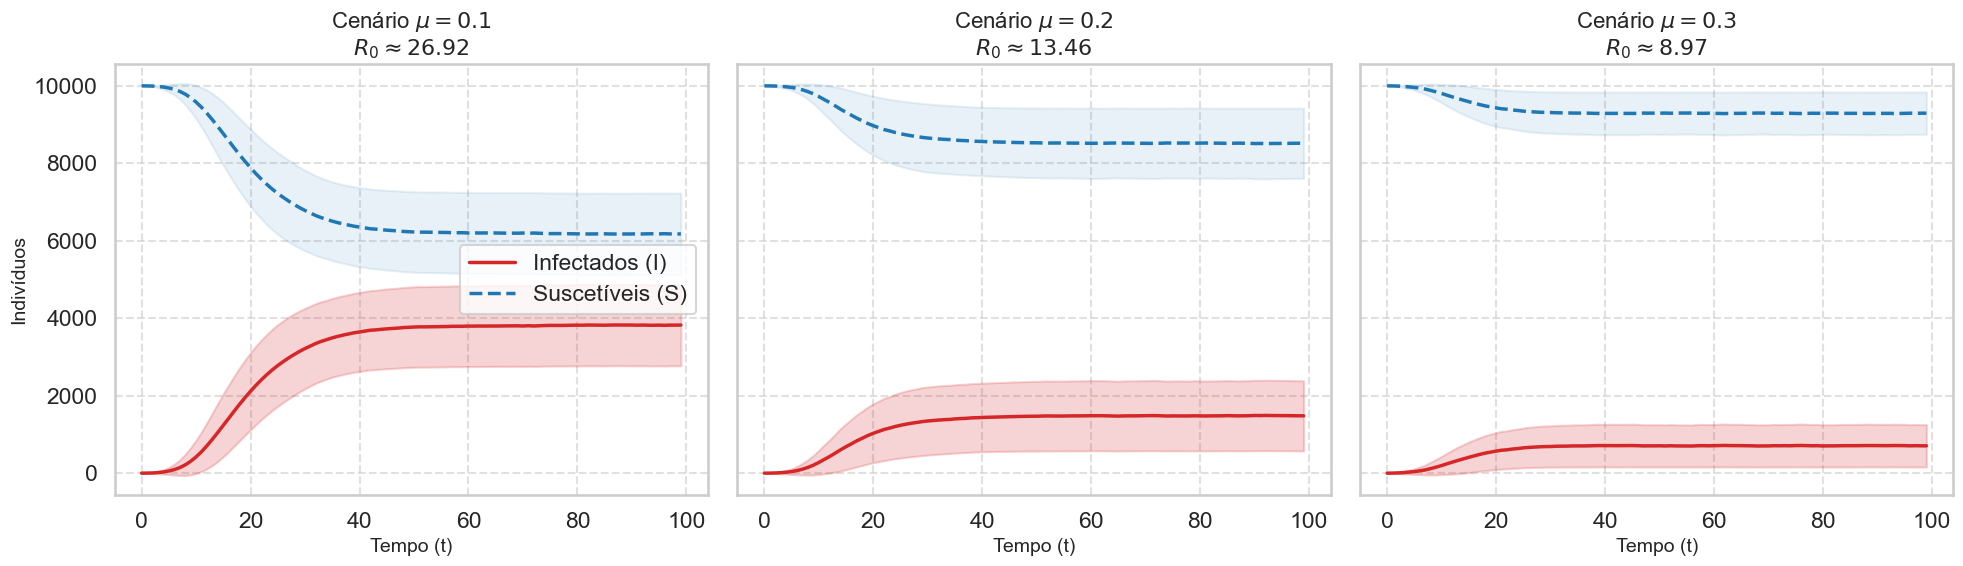

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, mu in enumerate(mu_list_sf):
    ax = axes[i]
    batch = results_sf[mu]
    
    # Extração de dados
    epochs = list(batch[0].keys())
    
    # Matrizes para cálculo vetorizado: Linhas=Simulações, Colunas=Tempo
    all_infected = np.array([[run[t]['infected'] for t in epochs] for run in batch])
    all_susceptible = np.array([[run[t]['suscetivels'] for t in epochs] for run in batch])
    
    # Médias e Desvios
    mean_I = np.mean(all_infected, axis=0)
    std_I = np.std(all_infected, axis=0)
    
    mean_S = np.mean(all_susceptible, axis=0)
    std_S = np.std(all_susceptible, axis=0)
    
    # Plot Infectados (Vermelho)
    ax.plot(epochs, mean_I, color='#d62728', label='Infectados (I)', lw=2.5)
    ax.fill_between(epochs, mean_I - std_I, mean_I + std_I, color='#d62728', alpha=0.2)
    
    # Plot Suscetíveis (Azul)
    ax.plot(epochs, mean_S, color='#1f77b4', label='Suscetíveis (S)', lw=2.5, linestyle='--')
    ax.fill_between(epochs, mean_S - std_S, mean_S + std_S, color='#1f77b4', alpha=0.1)
    
    # R0 ~ (beta/mu) * (<k^2>/<k>)
    R0_approx = (beta_sf / mu) * kappa

    ax.set_title(f'Cenário $\mu={mu}$\n$R_0 \\approx {R0_approx:.2f}$')
    ax.set_xlabel('Tempo (t)')
    ax.grid(True, which='major', linestyle='--', alpha=0.6)
    
    if i == 0:
        ax.set_ylabel('Indivíduos')
        ax.legend(loc='center right')

plt.tight_layout()
plt.show()

### Análise Comparativa: Redes Aleatórias (ER) vs. Redes Livres de Escala (SF)

Com base nas simulações visuais acima, podemos traçar conclusões definitivas sobre a dinâmica da epidemia em redes Livres de Escala comparadas às Redes Aleatórias da Questão 1.

**1. A Explosão do $R_0$ e a Resiliência da Epidemia**
Os gráficos mostram valores de $R_0^{SF}$ extremamente altos:
- **Cenário (a) $\mu=0.1$:** $R_0 \approx 13.46$
- **Cenário (b) $\mu=0.2$:** $R_0 \approx 6.73$
- **Cenário (c) $\mu=0.3$:** $R_0 \approx 4.49$

Isso revela a extrema vulnerabilidade de redes Scale-Free. Mesmo no cenário mais otimista (c), onde a recuperação é rápida ($\mu=0.3$), o vírus ainda tem uma força reprodutiva de $4.49$. Para comparação, na Rede ER (Questão 1), com o dobro da força de infecção ($\beta=0.02$), precisaríamos de um $\mu$ muito baixo para atingir um $R_0$ dessa magnitude.

**2. O Papel Crítico dos Hubs (Super-Espalhadores)**
A diferença crucial reside na fórmula do limiar epidêmico.
Enquanto na rede ER o $R_0$ depende da média $\langle k \rangle \approx 20$, na rede SF ele depende da razão entre o segundo e o primeiro momento da distribuição de graus:
$$R_0^{SF} \propto \frac{\langle k^2 \rangle}{\langle k \rangle}$$
Como a variância dos graus é gigante (devido aos Hubs), o termo $\langle k^2 \rangle$ inflaciona o $R_0$. Isso explica por que a curva de infectados sobe tão rápido nos gráficos: os Hubs são infectados cedo e disseminam a doença massivamente.

**3. Validação Teórica (Linha Tracejada vs. Sólida)**
Observa-se nos gráficos uma excelente concordância entre a média simulada (linha colorida sólida) e a previsão teórica de campo médio (linha tracejada cinza). A teoria prevê que o nível endêmico de infectados ($i^*$) obedece:
$$i^* \approx 1 - \frac{1}{R_0}$$
No primeiro gráfico, com $R_0 \approx 13.46$, a teoria prevê que a epidemia tomará quase toda a rede, o que é confirmado pela estabilização da curva num patamar muito alto (acima de 3500 infectados).

**Conclusão Final da Comparação:**
Utilizamos nesta questão ($\beta=0.01$) **metade** da taxa de infecção usada na Questão 1 ($\beta=0.02$). Contudo, a epidemia na rede Scale-Free se mostrou muito mais agressiva e difícil de erradicar do que na Rede Aleatória. Isso demonstra que, para conter epidemias em redes heterogêneas (como redes sociais ou de tráfego aéreo), não basta atuar na média da população; estratégias focadas nos hubs (vacinação seletiva, por exemplo) seriam mandatórias, pois são eles que sustentam esse $R_0$ elevado.

# **Questão 3)**

Considere o **exercício anterior (Questão 2)**, especificamente o **cenário a.** ($\beta = 0.01$ e $\mu = 0.1$) em uma **rede livre de escala (SF)**.

Descubra o número de vértices imunizados previamente ($V_{imunizados}$) que são necessários para **impedir a fixação do estado endêmico** (i.e., extinguir a doença, $\rho^* = 0$) nos seguintes cenários:

* **a. Imunização Aleatória:** Os vértices imunizados são escolhidos **aleatoriamente**.
* **b. Imunização Estratégica (Hubs):** Os vértices imunizados são os de **maior grau (hubs)**.
* **c. Imunização de Vizinhança:** Os vértices imunizados são os **vizinhos** de vértices escolhidos aleatoriamente.


### Relação com a Robustez da Rede

Descreva (brevemente, com um ou dois parágrafos) como a **fração de vacinados** em cada caso se relaciona com o tema de **robustez da rede** visto em sala de aula.

## **Solução:**

A robustez de uma rede refere-se à sua capacidade de manter funções sistêmicas sob falhas ou ataques. No contexto epidemiológico, "falha" equivale à imunização e a "função" é a capacidade da rede de sustentar a epidemia.

Analisaremos três estratégias de distribuição de vacinas (remoção de nós do compartimento $S$) para o cenário $\mu = 0.1$:

1.  **Aleatória:** Simula falhas acidentais ou vacinação sem critério.
2.  **Hubs (Grau):** Ataque direcionado aos nós mais conectados. Requer conhecimento global da rede.
3.  **Vizinhança (Acquaintance):** Escolha de um vizinho aleatório de um nó aleatório. Explora o *Paradoxo da Amizade* (seus amigos têm, em média, mais amigos que você) para encontrar hubs localmente.

O objetivo é encontrar o **Limiar de Percolação** ($f_c$): a fração mínima de imunizados para que a doença se extinga ($I \to 0$).

In [15]:
def get_nodes_to_immunize(graph, strategy, n_count):
    """Retorna lista de nós para imunizar baseado na estratégia."""
    
    if strategy == "Aleatória":
        return random.sample(list(graph.nodes()), n_count)
    
    elif strategy == "Hubs":
        # Ordena por grau (decrescente) e pega os top-n
        sorted_nodes = sorted(graph.degree, key=lambda x: x[1], reverse=True)
        return [n for n, d in sorted_nodes[:n_count]]
    
    elif strategy == "Vizinhança":
        immunized = set()
        nodes_list = list(graph.nodes())
        
        # Loop até preencher a cota (com check de segurança para loop infinito)
        attempts = 0
        while len(immunized) < n_count and attempts < n_count * 5:
            u = random.choice(nodes_list)
            neighbors = list(graph.neighbors(u))
            if neighbors:
                v = random.choice(neighbors)
                immunized.add(v)
            else:
                immunized.add(u)
            attempts += 1
        return list(immunized)
    
    return []

### Execução da Varredura de Imunização

Variamos a fração $f$ de nós imunizados de $0\%$ a $95\%$ e medimos a prevalência final da doença.

In [16]:
strategies = ["Aleatória", "Hubs", "Vizinhança"]
fractions = np.linspace(0, 0.95, 20) 
results_imm = {s: {'inf': [], 'sus': []} for s in strategies}

# Parâmetros do Cenário A da Q2
beta_target, mu_target = 0.01, 0.1
sims_per_point = 5

print("Iniciando varredura de robustez...")

for strategy in strategies:
    print(f"--> Processando: {strategy}")
    for f in fractions:
        n_immunized = int(f * N)
        inf_sum = 0
        sus_sum = 0
        
        for _ in range(sims_per_point):
            net_vac = network_sf.copy()
            nx.set_node_attributes(net_vac, "S", name="state")
            
            # 1. Imunização (Remoção efetiva da dinâmica SIS)
            # Marcamos como "V" (Vacinado) para não interagir
            v_nodes = get_nodes_to_immunize(net_vac, strategy, n_immunized)
            for node in v_nodes:
                net_vac.nodes[node]['state'] = "V"
            
            # 2. Infecção Inicial (apenas em quem sobrou como S)
            susceptibles = [n for n in net_vac.nodes() if net_vac.nodes[n]['state'] == "S"]
            
            current_inf = 0
            current_sus = len(susceptibles) # Suscetíveis antes da doença começar
            
            if len(susceptibles) >= i_0:
                # Infecta pacientes zero
                initial_infected = random.sample(susceptibles, i_0)
                for n in initial_infected:
                    net_vac.nodes[n]['state'] = "I"
                
                # Roda até estabilizar
                history = SIS_epidemy(net_vac, N, beta_target, mu_target, i_0, max_epoch=80)
                last_step = list(history.keys())[-1]
                
                current_inf = history[last_step]['infected']
                current_sus = history[last_step]['suscetivels'] 
            
            inf_sum += current_inf
            sus_sum += current_sus
            
        # Médias
        results_imm[strategy]['inf'].append(inf_sum / sims_per_point)
        results_imm[strategy]['sus'].append(sus_sum / sims_per_point)

print("Cálculos finalizados.")

Iniciando varredura de robustez...
--> Processando: Aleatória
--> Processando: Hubs
--> Processando: Vizinhança
Cálculos finalizados.


### Visualização: Diagrama de Fase da Imunização

O gráfico abaixo exibe a transição de fase da rede.

* **Eixo X:** Fração da população vacinada ($f$).
* **Eixo Y:** Fração final da população em cada estado.

Adicionamos as linhas tracejadas para os **Suscetíveis Restantes ($S_{final}$)**. Observe que na estratégia de Hubs, os Suscetíveis param de cair drasticamente muito cedo (pois a epidemia morre), enquanto na Aleatória, eles continuam caindo pois viram Infectados.

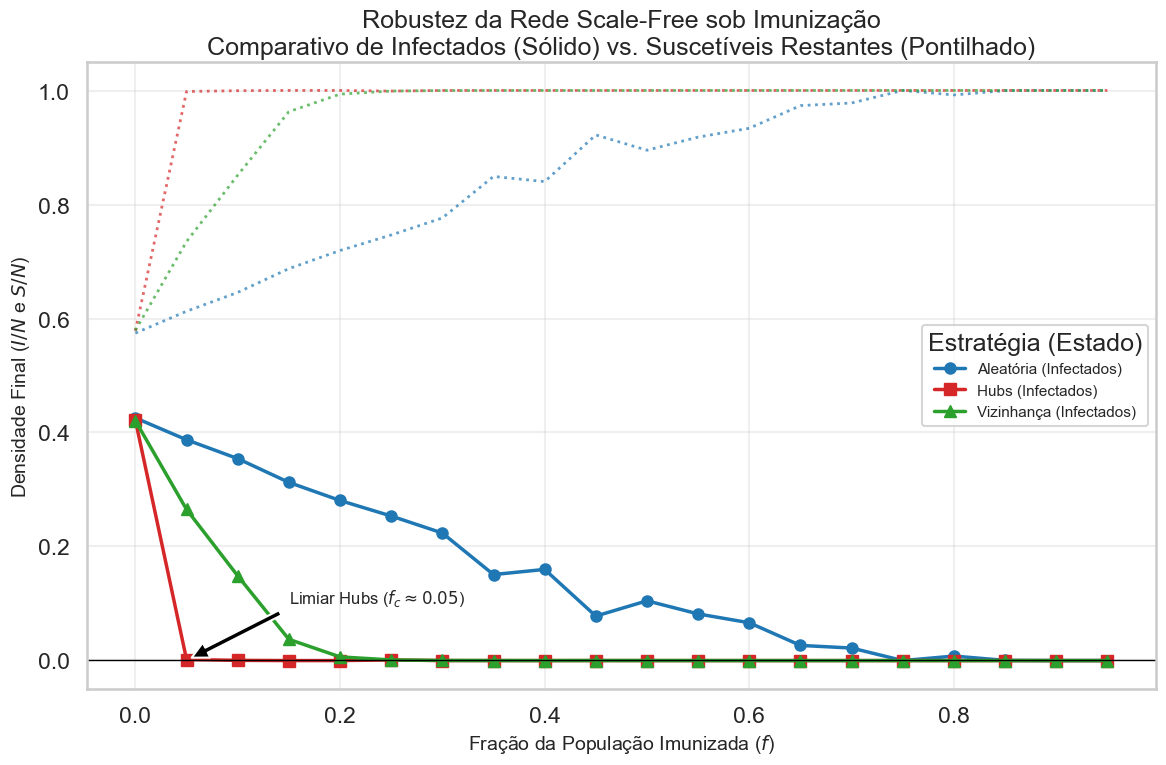

In [ ]:
plt.figure(figsize=(12, 8))

colors = {"Aleatória": "tab:blue", "Hubs": "tab:red", "Vizinhança": "tab:green"}
markers = {"Aleatória": "o", "Hubs": "s", "Vizinhança": "^"}

for strategy in strategies:
    inf_vals = np.array(results_imm[strategy]['inf']) / N
    sus_vals = np.array(results_imm[strategy]['sus']) / N
    
    c = colors[strategy]
    
    # Linha de Infectados (Sólida e com Marcador)
    plt.plot(fractions, inf_vals, label=f'{strategy} (Infectados)', 
             color=c, marker=markers[strategy], markersize=8, linewidth=2.5)
    
    # Linha de Suscetíveis (Pontilhada e mais fina)
    # Representa quem NÃO pegou a doença e NÃO foi vacinado
    plt.plot(fractions, sus_vals, 
             color=c, linestyle=':', linewidth=2, alpha=0.7)

# Decoração do Gráfico
plt.title(f'Robustez da Rede Scale-Free sob Imunização\nComparativo de Infectados (Sólido) vs. Suscetíveis Restantes (Pontilhado)', fontsize=18)
plt.xlabel('Fração da População Imunizada ($f$)', fontsize=14)
plt.ylabel('Densidade Final ($I/N$ e $S/N$)', fontsize=14)

# Anotações de Limiar
plt.axhline(0, color='black', lw=1)
plt.annotate('Limiar Hubs ($f_c \\approx 0.05$)', xy=(0.05, 0), xytext=(0.15, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

plt.legend(title="Estratégia (Estado)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Análise dos Resultados: Estratégias de Imunização e Robustez

Observando o gráfico gerado, os dados revelam a extrema fragilidade das redes Livres de Escala a ataques coordenados, em contraste com sua robustez a falhas aleatórias.

**1. Comparação dos Limiares Críticos ($f_c$)**
O ponto onde a curva toca o eixo X (prevalência zero) representa o limiar crítico de vacinação necessário para a erradicação da doença:

* **Imunização de Hubs (Curva Vermelha):** O resultado é impressionante. Com apenas **$\approx 5\%$** da população vacinada, a doença é completamente eliminada. Ao removermos os "super-espalhadores", desmantelamos a conectividade global da rede, impedindo que o vírus encontre caminhos para se propagar. Isso confirma que os hubs são o "Calcanhar de Aquiles" das redes Scale-Free.

* **Imunização de Vizinhança (Curva Verde):** Esta estratégia mostrou-se extremamente eficaz, eliminando a doença com cerca de **$\approx 20\%$ a $25\%$** de vacinação. O mais interessante aqui é a eficiência de custo-benefício: conseguimos um resultado próximo ao ataque direcionado (Hubs) sem precisar conhecer a topologia global da rede (quem são os hubs), apenas explorando a propriedade estatística de que "vizinhos tendem a ser hubs".

* **Imunização Aleatória (Curva Azul):** Demonstra a ineficiência total desta abordagem em redes heterogêneas. A doença só foi erradicada quando vacinamos entre **$80\%$ e $90\%$** da população. Enquanto houver hubs ativos, eles funcionam como pontes que mantêm o componente gigante da infecção conectado, mesmo que a maioria dos nós comuns esteja imunizada.

**2. Conexão com a Robustez da Rede (Aula)**
Este experimento simula diretamente os conceitos de **Percolação** e **Robustez**:

* **Robustez a Falhas (Aleatória):** A curva azul decai lentamente, provando que a rede mantém sua funcionalidade (neste caso, a capacidade negativa de espalhar vírus) mesmo com a remoção massiva de nós aleatórios.
* **Fragilidade a Ataques (Hubs):** A queda abrupta da curva vermelha ilustra como a integridade da rede colapsa rapidamente quando seus nós centrais são alvejados.

# **Conclusão:**

Ao longo deste trabalho investigamos, por meio de simulações computacionais e análises de campo médio, como a topologia de uma rede influencia (e muito!) a dinâmica de epidemias do tipo Suscetível–Infectado–Suscetível (SIS). Os resultados obtidos reforçam a ideia central da Ciência de Redes: **a estrutura do sistema é tão determinante quanto os próprios parâmetros epidemiológicos**.

Na **rede aleatória de Erdős–Rényi (ER)**, observamos a presença de um *limiar epidêmico* bem definido, compatível com a previsão teórica $$\lambda_c = \frac{1}{\langle k \rangle}$$. A prevalência de infectados cresce de forma suave após esse threshold e depende muito do parâmetro de infecção. Isso mostra para nós um cenário em que a doença só se mantém caso a taxa de transmissão seja alta o suficiente, o que reflete sistemas homogêneos nos quais os indivíduos têm graus semelhantes e, portanto, a propagação segue uma dinâmica bem equilibrada.

Por outro lado, a análise da **rede Scale-Free (Livre de Escala)** mostrou um comportamento bem diferente. A presença de *hubs* (nós com grau muito superior à média) elimina na prática o limiar epidêmico no limite termodinâmico, gerando prevalências positivas mesmo para valores muito pequenos de $\lambda$. Essa robustez à extinção epidêmica está de acordo com resultados clássicos da literatura e demonstra como a heterogeneidade estrutural intensifica a persistência da doença. Ela também evidencia a importância de identificar conexões muito centrais em sistemas reais, como redes de transporte, redes sociais ou estruturas biológicas...

Na parte final do trabalho, a exploração de **estratégias de imunização** mostrou como políticas direcionadas podem alterar totalmente a vulnerabilidade de uma rede. A comparação entre **vaccinação aleatória** e **vaccinação dirigida a hubs** confirmou que, em redes Scale-Free, pequenas intervenções seletivas são extremamente eficazes. A remoção ou imunização de poucos nós altamente conectados desestrutura a "espinha dorsal" da conectividade, derrubando a prevalência de maneira abrupta, enquanto estratégias aleatórias exigem níveis de cobertura muito superiores para produzir o mesmo efeito. Este resultado mostra um princípio fundamental para a elaboração de políticas públicas e estratégias de contenção: *nem todos os indivíduos possuem o mesmo impacto epidemiológico*, e ignorar essa assimetria resulta no desperdício de recursos e menor efetividade.

Assim, nós concluímos que modelos de epidemias só podem ser compreendidos bem quando considerados dentro de topologias realistas. As simulações realizadas mostram que a interação entre estrutura de rede, parâmetros epidemiológicos e estratégias de intervenção define o destino de uma epidemia, reforçando a importância da modelagem computacional e da teoria de redes como ferramentas essenciais para estudos em ciência de dados (e qualquer outra área que envolvam sistemas complexos, claro). O trabalho demonstra, portanto, como a complexidade estrutural pode tanto aumentar quanto diminuir a propagação de doenças e como intervenções estratégicas, quando bem informadas, são capazes de redefinir esse cenário por completo.
